**COCO (Common Objects in COntext)** is a popular dataset in Computer Vision. It contains annotations for Computer Vision tasks - object detection, segmentation, keypoint detection, stuff segmentation, panoptic segmentation, densepose, and image captioning. For more details visit https://cocodataset.org/#format-data

The Tensor Processing Unit (TPU) hardware accelerators  are very fast. The challenge is often to feed them data fast enough to keep them busy. Google Cloud Storage (GCS) is capable of sustaining very high throughput but as with all cloud storage systems, initiating a connection costs some network back and forth. Therefore, having our data stored as thousands of individual files is not ideal. We are going to batch the **COCO dataset with object detection annotations** in a smaller number of files and use the power of tf.data.Dataset to read from multiple files in parallel. 

**The TFRecord file format**<br>
Tensorflow's preferred file format for storing data is the protobuf-based TFRecord format. Other serialization formats would work too but you can load a dataset from TFRecord files directly by writing:

`
filenames = tf.io.gfile.glob(FILENAME_PATTERN)
dataset = tf.data.TFRecordDataset(filenames)
dataset = dataset.map(...)
`

For more details https://codelabs.developers.google.com/codelabs/keras-flowers-data/

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
import skimage.io as io
import os

Annotations are stored using JSON. COCO API can be used to access and manipulate all anotations.

In [2]:
!pip install -q pycocotools
from pycocotools.coco import COCO

This notebook use validation set due to the 5GB size limit of /kaggle/working folder. training set is around 20 GB in size. You can use training set by changing follwing paths to training set paths.

In [3]:
img_dir=('/kaggle/input/coco2017/val2017/val2017/')
annotations_file='/kaggle/input/coco2017/annotations_trainval2017/annotations/instances_val2017.json'

In [4]:
#Loading object detection annotations of 2017 validation set using COCO API
coco=COCO(annotations_file)

loading annotations into memory...
Done (t=1.82s)
creating index...
index created!


Details of each image in COCO dataset are stored in following format. 

`image{
"id": int, "width": int, "height": int, "file_name": str, "license": int, "flickr_url": str, "coco_url": str, "date_captured": datetime,
}`

A image may have multiple annotaions.

Each object instance annotation contains a series of fields, including the category id and segmentation mask of the object. The segmentation format depends on whether the instance represents a single object (iscrowd=0 in which case polygons are used) or a collection of objects (iscrowd=1 in which case RLE is used). Note that a single object (iscrowd=0) may require multiple polygons, for example if occluded. Crowd annotations (iscrowd=1) are used to label large groups of objects (e.g. a crowd of people). In addition, an enclosing bounding box is provided for each object (box coordinates are measured from the top left image corner and are 0-indexed).

annotation is mapped to image by using image_id.

`annotation{
"id": int, "image_id": int, "category_id": int, "segmentation": RLE or [polygon], "area": float, "bbox": [x,y,width,height], "iscrowd": 0 or 1,
}`

Visit https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb for COCO API demo.

In [5]:
#validation set details
imgIds = coco.getImgIds()
print("Total images: {}".format(len(imgIds)))
rand=np.random.randint(0,len(imgIds))
img = coco.loadImgs(imgIds[rand])[0]
print("Image example:")
print(img)
annIds=coco.getAnnIds()
print("\nTotal annotations: {}".format(len(annIds)))
ann=coco.loadAnns(coco.getAnnIds(imgIds=img['id']))
print("Annotation example:")
print(ann[0])

Total images: 5000
Image example:
{'license': 4, 'file_name': '000000570756.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000570756.jpg', 'height': 428, 'width': 640, 'date_captured': '2013-11-22 18:42:22', 'flickr_url': 'http://farm4.staticflickr.com/3035/2385648150_d58d525cbe_z.jpg', 'id': 570756}

Total annotations: 36781
Annotation example:
{'segmentation': [[222.33, 353.61, 248.87, 352.68, 289.3, 342.19, 291.3, 339.26, 250.87, 346.2, 244.09, 346.82, 242.7, 334.94, 223.1, 350.68, 216.93, 345.74, 202.58, 335.09, 202.58, 337.71, 217.7, 352.84]], 'area': 524.4832500000007, 'iscrowd': 0, 'image_id': 570756, 'bbox': [202.58, 334.94, 88.72, 18.67], 'category_id': 38, 'id': 623597}


Each COCO object detection annotation have a category id.  The categories field of the annotation structure stores the mapping of category id to category and supercategory names. 

`categories[{
"id": int,
"name": str,
"supercategory": str,
}]`

In [6]:
cats = coco.loadCats(coco.getCatIds())
print("Number of categories: {}".format(len(cats)))
nms=[cat['name'] for cat in cats]
print('\nCOCO categories: \n{}\n'.format(' '.join(nms)))

Number of categories: 80

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush



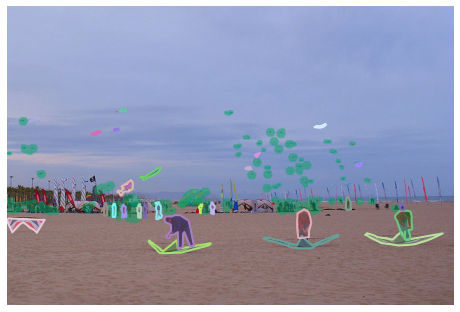

In [7]:
#Example
I = io.imread(img['coco_url'])
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'])
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [8]:
#Create tfrecord output directories
!mkdir '/kaggle/working/COCO2017/'
!mkdir '/kaggle/working/COCO2017/val_tfrecords/'
records_path='/kaggle/working/COCO2017/val_tfrecords/'

In [9]:
#Returns all the annotation data for a given image id
def get_annotations(imgId):
    annIds=coco.getAnnIds(imgIds=imgId)
    anns=coco.loadAnns(annIds)
    segmentations=[]
    segmentation_lengths=[]
    bboxes=[]
    catIds=[]
    iscrowd_list=[]
    area_list=[]
    annotation_ids=[]
    for ann in anns:
        try:
            catId=ann['category_id']
            bbox=ann['bbox']
            segmentation=ann['segmentation'][0]
            iscrowd=ann['iscrowd']
            area=ann['area']
            annotation_id=ann['id']
        except:
            continue
        if((not None in bbox) and (None!=catId)):
            catIds.append(catId)
            segmentations.append(segmentation)
            segmentation_lengths.append(len(segmentation))
            bboxes.append(bbox)
            iscrowd_list.append(iscrowd)
            area_list.append(area)
            annotation_ids.append(annotation_id)
    return len(anns),catIds,segmentation_lengths,sum(segmentations,[]),sum(bboxes,[]),iscrowd_list,area_list,annotation_ids

The tf.Example message (or protobuf) is a flexible message type that represents a {"string": value} mapping. In TFRecord files, all the available data for a image will be stored using tf.Example. For more details, visit https://www.tensorflow.org/tutorials/load_data/tfrecord#tfexample

get_annotations function returns all the annotation data for a given image id. 

One tf.Example will be created with image data and annotation data for each image. These examples will be written into multiple tfrecord files. 

The number of tfrecord files to be created is based on image size. The rule of thumb is to split your data across several (10s to 100s) larg-ish files (10s to 100s of MB). If you have too many files, thousands of files for example, the time to access each file might start getting in the way. If you have too few files, like one or two, then you are not getting the benefits of streaming from multiple files in parallel.

In [10]:
#Size of each TFRecord file will be 100MB for improving performance
n=len(imgIds)
imgids=imgIds[0:n]
size=0
for i in imgids:
    img=coco.loadImgs(i)
    fn=img[0]['file_name']
    size+=os.path.getsize(img_dir+fn)
avg_size=size/n
limit=int(104857600//avg_size)
total_tfrecords=int(len(imgIds)//limit)
print("{} TFRecord files will be created".format(total_tfrecords))

for i in range(0,total_tfrecords):
    examples=[]
    start=i*limit
    end=start+limit
    imgids=imgIds[start:end]
    
    for img in coco.loadImgs(imgids):
        with open(str(img_dir)+img['file_name'],'rb') as f:
            image_string=f.read()

        objects,catIds,segmentation_lengths,segmentations,bboxes,iscrowd,area,annotation_ids=get_annotations(img['id'])

        # Create a Features message using tf.train.Example.
        example = tf.train.Example(features=tf.train.Features(feature={
            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_string])),
            'height': tf.train.Feature(int64_list=tf.train.Int64List(value=[img['height']])),
            'width': tf.train.Feature(int64_list=tf.train.Int64List(value=[img['width']])),
            'id': tf.train.Feature(int64_list=tf.train.Int64List(value=[img['id']])),
            'license': tf.train.Feature(int64_list=tf.train.Int64List(value=[img['license']])),
            'file_name': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(img['file_name'])])),
            'coco_url': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(img['coco_url'])])),
            'flickr_url': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(img['flickr_url'])])),
            'date_captured': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(img['date_captured'])])),
            #objects-Number of objects in the image
            'objects': tf.train.Feature(int64_list=tf.train.Int64List(value=[objects])),
            #Follwing features hold all the annotations data given for the image
            #category_ids-List of aannotation category ids
            'category_ids': tf.train.Feature(int64_list=tf.train.Int64List(value=catIds)),
            #segmentation_lengths-List of segmentation lengths
            'segmentation_lengths': tf.train.Feature(int64_list=tf.train.Int64List(value=segmentation_lengths)),
            #segmention lists flattened into 1D list
            'segmentations': tf.train.Feature(float_list=tf.train.FloatList(value=segmentations)),
            #bboxes flattened into 1D list
            'bboxes': tf.train.Feature(float_list=tf.train.FloatList(value=bboxes)),
            #List of iscrowd values
            'iscrowd': tf.train.Feature(int64_list=tf.train.Int64List(value=iscrowd)),
            #List of area values
            'area': tf.train.Feature(float_list=tf.train.FloatList(value=area)),
            #List of annotation ids 
            'annotation_ids': tf.train.Feature(int64_list=tf.train.Int64List(value=annotation_ids)),
        }))
        examples.append(example)
    
    with tf.io.TFRecordWriter(records_path+'coco'+str(i)+'.tfrecord') as writer:
        for j in examples:
            writer.write(j.SerializeToString())
    examples.clear()
    print("file {} created".format(i))

7 TFRecord files will be created
file 0 created
file 1 created
file 2 created
file 3 created
file 4 created
file 5 created
file 6 created


In [11]:
#zip the created tfrecord files. 
#!find records_path -type f -exec zip -g tfrecords.zip {} \; -exec rm {} \;

tf.io.parse_single_example is used to parse a example in tfrecord dataset. Number of objects in the image is not same for all images. So annotation data should be retrieved using VarLenFeature. VarLenFeature returns a sparse tensor.

All the Segmentation and bbox data for a image are flattened into a 1D array when storing the data in tfrecord files. For example,<br>
two bboxes of a image [100,70,70,80] and [120,88,200,300] are flattened into [100,70,70,80,120,88,200,300] . 
two segmentations of a image [23,45,67,89,45,43,23,12] and [78,123,156] are flattened into [23,45,67,89,45,43,23,12,78,123,156].

objects and segmentation_lengths data are used to retrieve the bbox and segmentation data.

In [12]:
def parse(feature):
    features = tf.io.parse_single_example(
        feature,
        features={
        'image': tf.io.FixedLenFeature([], tf.string),
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'id': tf.io.FixedLenFeature([], tf.int64),
        'license': tf.io.FixedLenFeature([], tf.int64),
        'file_name': tf.io.FixedLenFeature([], tf.string),
        'coco_url': tf.io.FixedLenFeature([], tf.string),
        'flickr_url': tf.io.FixedLenFeature([], tf.string),
        'date_captured': tf.io.FixedLenFeature([], tf.string),
        'objects': tf.io.FixedLenFeature([], tf.int64),
        'category_ids': tf.io.VarLenFeature(tf.int64),
        'segmentation_lengths': tf.io.VarLenFeature(tf.int64),
        'segmentations': tf.io.VarLenFeature(tf.float32),
        'bboxes': tf.io.VarLenFeature(tf.float32),
        'iscrowd': tf.io.VarLenFeature(tf.int64),
        'area': tf.io.VarLenFeature(tf.float32),
        'annotation_ids': tf.io.VarLenFeature(tf.int64),
        
    })

    
    print('Image id:')
    print(features['id'])
    print('\nlicense:')
    print(features['license'])
    print('\nfile_name:')
    print(features['file_name'])
    print('\ncoco_url:')
    print(features['coco_url'])
    print('\nflickr_url:')
    print(features['flickr_url'])
    print('\ndate_captured:')
    print(features['date_captured'])
    print("\nobjects:")
    print(features['objects'])
    print("\nheight:")
    print(features['height'])
    print("\nwidth:")
    print(features['width'])
    print("\ncategory ids:")
    print(features['category_ids'])
    print("\niscrowd:")
    print(features['iscrowd'])
    print("\narea:")
    print(features['area'])
    print("\nannotation_ids:")
    print(features['annotation_ids'])
    
    
    
    objects = features['objects']
    bboxes = features['bboxes']
    bboxes = tf.sparse.to_dense(bboxes)
    bboxes = tf.reshape(bboxes, [objects, 4])
    
    print("\nbboxes:")
    print(bboxes)
    
    print("\nsegmentation lengths:")
    print(features['segmentation_lengths'])
    
    segmentations = features['segmentations']
    segmentations = tf.sparse.to_dense(segmentations)
    segmentation_lengths=tf.sparse.to_dense(features['segmentation_lengths'])
    

    segs=[]
    start=0
    for i in segmentation_lengths:
        segs.append(tf.slice(segmentations,[start,],[i,]))
        start+=i
    print("\nSegmentations:")    
    print(segs)
    
    image = tf.image.decode_jpeg(features['image'], channels=3)
    plt.imshow(image); plt.axis('off')
    
    anns=[]
    for i in range(0,len(segs)):
        #plt.gca().add_patch(Rectangle((i[0],i[1]),i[2],i[3],linewidth=1,edgecolor='r',facecolor='none'))
        ann={}
        ann['segmentation']=[segs[i].numpy().tolist()]
        ann['bbox']=bboxes[i].numpy().tolist()
        anns.append(ann)
    #print(anns)
    coco.showAnns(anns,draw_bbox=True)
    

Image id:
tf.Tensor(425221, shape=(), dtype=int64)

license:
tf.Tensor(3, shape=(), dtype=int64)

file_name:
tf.Tensor(b'000000425221.jpg', shape=(), dtype=string)

coco_url:
tf.Tensor(b'http://images.cocodataset.org/val2017/000000425221.jpg', shape=(), dtype=string)

flickr_url:
tf.Tensor(b'http://farm6.staticflickr.com/5504/9661315975_3822bd42f3_z.jpg', shape=(), dtype=string)

date_captured:
tf.Tensor(b'2013-11-16 05:13:27', shape=(), dtype=string)

objects:
tf.Tensor(23, shape=(), dtype=int64)

height:
tf.Tensor(640, shape=(), dtype=int64)

width:
tf.Tensor(480, shape=(), dtype=int64)

category ids:
SparseTensor(indices=tf.Tensor(
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]], shape=(23, 1), dtype=int64), values=tf.Tensor([ 5  1  1 15 15 15 15 27 62 62 62 62 62 62 62 62 62 15  5 33 62 62 62], shape=(23,), dtype=int64), dense_shape=tf.Tensor([23], shape=(1,), dtype=int64))

iscrowd:
SparseTe

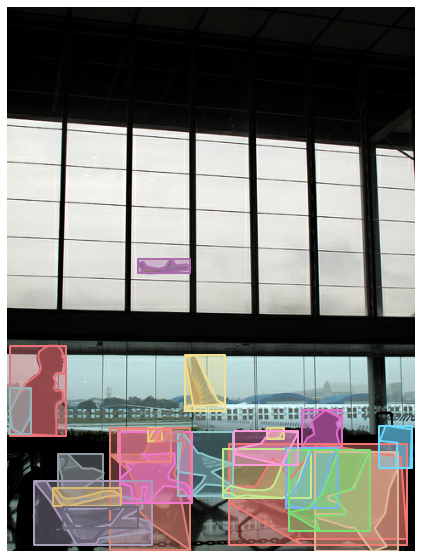

In [13]:
dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(records_path+'*.tfrecord'))
for i in dataset.take(1):
    parse(i)